In [17]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import librosa 
from scipy.fftpack import fft
import pywt

In [18]:
# read .mat file
from scipy.io import loadmat
mat = loadmat('data/HPCpyra_events.mat')
mat = loadmat('data/PFCshal_events.mat')
mat.keys()


dict_keys(['__header__', '__version__', '__globals__', 'PFCshal_complex_swr_veh', 'PFCshal_ripple_veh', 'PFCshal_swr_veh'])

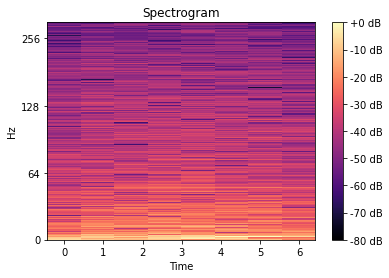

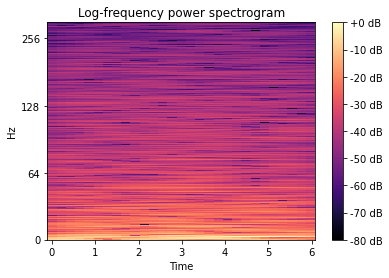

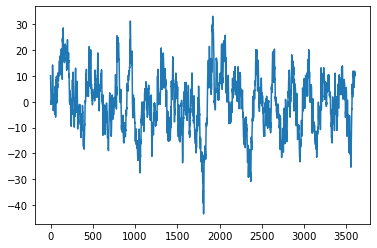

In [19]:
dataset = 'PFCshal_complex_swr_veh'
y, sr = mat[dataset][0] , 600

spec = np.abs(librosa.stft(y,))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')



fig, ax = plt.subplots()

hop_length = 128

D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                            ref=np.max)
img = librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,

                         x_axis='time', ax=ax)
ax.set(title='Log-frequency power spectrogram')
ax.label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

fig, ax = plt.subplots()

plt.plot(mat[dataset][0])

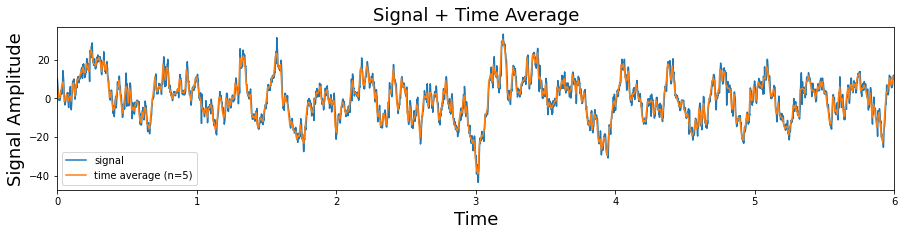

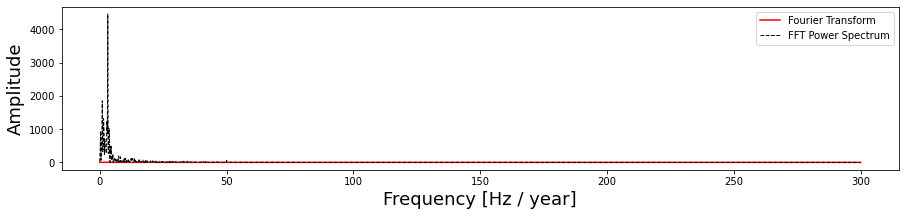

scale pseudo frequencies [600.         300.         200.         150.         120.
 100.          85.71428571] (7,)


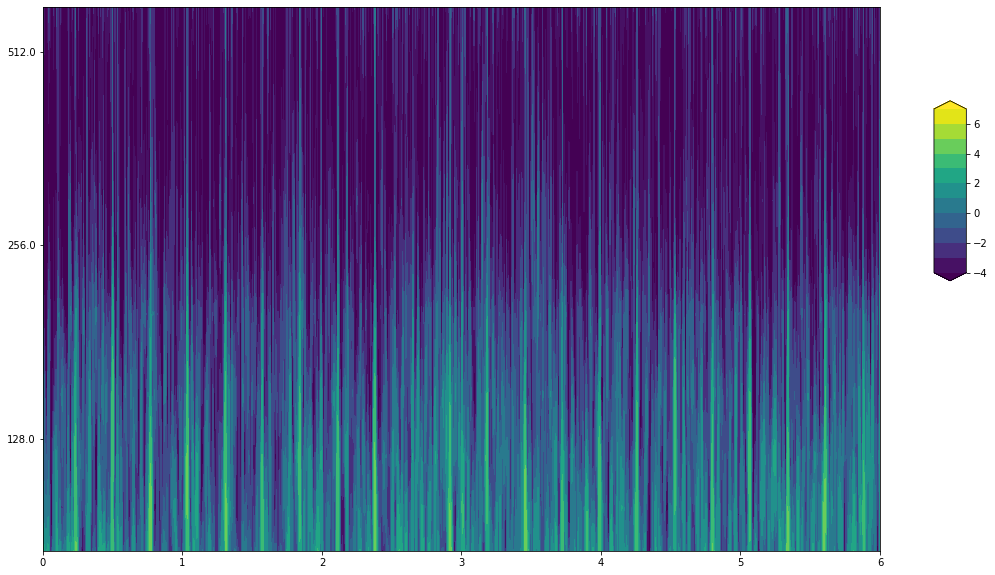

In [22]:

#taken from https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
def plot_wavelet_freq(time, signal, scales, 
                 waveletname = 'mor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,16,32,64,128]
    contourlevels = np.log2(levels)
    print('scale pseudo frequencies',frequencies,frequencies.shape)
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=cmap)
        
    yticks =  2**np.arange(np.ceil(np.log2(frequencies.min())), np.ceil(np.log2(frequencies.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")

    plt.show()

def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()


def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    plt.show()
def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave


df, sr= pd.DataFrame(mat[dataset][0]), 600
N = df.shape[0]
t0=0
dt=1/sr
time = np.arange(0, N) * dt + t0
signal = df.values.squeeze()

scales = np.arange(1, 8)


plot_signal_plus_average(time, signal)
plot_fft_plus_power(time, signal)
# plot_wavelet(time, signal, scales)
plot_wavelet_freq(time, signal, scales,waveletname='cmor1.5-1.0',cmap=None)


In [34]:
#check relation between scales and frequencies
pywt.scale2frequency('cmor1.5-1.0',np.arange(1, 32))/dt


array([600.        , 300.        , 200.        , 150.        ,
       120.        , 100.        ,  85.71428571])